# Question analysis

Jakub Fołtyn  
Kacper Grzymkowski  
Marceli Korbin  
Mikołaj Malec

In [28]:
import numpy as np
import pandas as pd
import tqdm
import json
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from awq import AutoAWQForCausalLM
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split

## Sentence embedding
Using the all-MiniLM-L6-v2 sentence transformer (https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) and sentences taken from the SQuAD dataset

### Prepare assets

In [3]:
sentences = open('squad.txt', encoding='utf8').readlines()
sentences[:10]

['to whom did the virgin mary allegedly appear in 1858 in lourdes france ?\n',
 'what is in front of the notre dame main building ?\n',
 'the basilica of the sacred heart at notre dame is beside to which structure ?\n',
 'what is the grotto at notre dame ?\n',
 'what sits on top of the main building at notre dame ?\n',
 'when did the scholastic magazine of notre dame begin publishing ?\n',
 "how often is notre dame 's the juggler published ?\n",
 'what is the daily student paper at notre dame called ?\n',
 'how many student news papers are found at notre dame ?\n',
 'in what year did the student paper common sense begin publication at notre dame ?\n']

In [3]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(sentences)
np.save('squad-embeddings', embeddings)

### AWQ model and tokenizer

In [2]:
model_name = "TheBloke/Mistral-7B-v0.1-AWQ"
tokenizer_name = "mistralai/Mistral-7B-v0.1"
model = AutoAWQForCausalLM.from_quantized(model_name,
                                          fuse_layers=True,
                                          trust_remote_code=False,
                                          safetensors=True)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name,
                                          trust_remote_code=False)

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Fusing layers...: 100%|██████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.61it/s]


### Labelling process

Label meaning:
* from 1 to 6: Bloom's Taxonomy classification
* -1: not analyzed
* -2: generation failure

In [3]:
def sentence_rating(prompt, prompt_template):
    tokenizer.pad_token = tokenizer.eos_token
    tokens = tokenizer(
        prompt_template.format(prompt.strip()),
        return_tensors='pt',
        padding=True
    ).input_ids.cuda()
    
    generation_output = model.generate(
        tokens,
        do_sample=True,
        temperature=0.7,
        top_p=0.95,
        top_k=10,
        max_new_tokens=1
    )
    return tokenizer.decode(generation_output[0][-1])

In [32]:
def update_label(label):
    try:
        new_label = int(label)
    except:
        new_label = -2
    return new_label

In [5]:
prompt_template_1 = '''Bloom's Taxonomy is a hierarchical ordering of cognitive skills that can help teachers and students in the classroom. There are multiple levels of understanding: 
1 - Knowledge
2 - Comprehension
3 - Application
4 - Analysis
5 - Synthesis
6 - Evaluation.
For example, the question '{}' is considered to be of level '''

In [6]:
prompt_template_2 = '''Bloom's Taxonomy is a hierarchical ordering of cognitive skills that can help teachers and students in the classroom. There are multiple levels of understanding: 
1 - Knowledge, which relates to identification and recall of information,
2 - Comprehension, which relates to organization and selection of facts and ideas,
3 - Application, which relates to the use of facts, rules and principles,
4 - Analysis, which relates to separation of a whole into component parts,
5 - Synthesis, which relates to the combination fo ideas to form a new whole,
6 - Evaluation. which relates to developing opinions, judgements or decisions.

For example, the question '{}' is considered to be of level '''

In [24]:
ratings_1 = []
ratings_2 = []
prompts = list(tqdm.notebook.tqdm(sentences))
prompts_number = 100

  0%|          | 0/86635 [00:00<?, ?it/s]

In [25]:
for prompt in tqdm.notebook.tqdm(prompts[:prompts_number]):
    rating_1 = sentence_rating(prompt, prompt_template_1)
    rating_2 = sentence_rating(prompt, prompt_template_2)
    ratings_1.append(rating_1)
    ratings_2.append(rating_2)

  0%|          | 0/100 [00:00<?, ?it/s]

In [33]:
all_labels1 = [-1 for _ in sentences]
all_labels2 = [-1 for _ in sentences]

for index in range(prompts_number):
    label1, label2 = ratings_1[index], ratings_2[index]
    all_labels1[index] = update_label(label1)
    all_labels2[index] = update_label(label2)

json.dump(all_labels1, open('squad-labels-1.json', 'w'))
json.dump(all_labels2, open('squad-labels-2.json', 'w'))

### Label overview

In [34]:
label_dataframe = pd.DataFrame({"sentences": sentences, "label": all_labels1, "label2": all_labels2})

In [35]:
label_dataframe

,sentences,label,label2
0,to whom did the virgin mary allegedly appear i...,1,1
1,what is in front of the notre dame main buildi...,1,1
2,the basilica of the sacred heart at notre dame...,1,1
3,what is the grotto at notre dame ?\n,1,1
4,what sits on top of the main building at notre...,1,1
...,...,...,...
86630,in what us state did kathmandu first establish...,-1,-1
86631,what was yangon previously known as ?\n,-1,-1
86632,with what belorussian city does kathmandu have...,-1,-1
86633,in what year did kathmandu create its initial ...,-1,-1


In [37]:
label_dataframe[label_dataframe["label"]>1]

,sentences,label,label2
6,how often is notre dame 's the juggler publish...,2,1
58,work on a germ-free-life ended up in the creat...,2,2
71,what threat does the global adaptation index s...,2,1
92,what type of education was pushed at notre dam...,3,3
96,those who attended a jesuit college may have b...,6,4


In [39]:
label_dataframe[label_dataframe["label2"]>1]

,sentences,label,label2
13,what individuals live at fatima house at notre...,1,2
20,what entity provides help with the management ...,1,2
40,where does notre dame rank in terms of academi...,1,3
58,work on a germ-free-life ended up in the creat...,2,2
64,what was the review of politics inspired by ?\n,1,3
73,what percentage of students at notre dame are ...,1,2
92,what type of education was pushed at notre dam...,3,3
96,those who attended a jesuit college may have b...,6,4


In [40]:
label_dataframe[label_dataframe["label"] != label_dataframe["label2"]].head(49)

,sentences,label,label2
6,how often is notre dame 's the juggler publish...,2,1
13,what individuals live at fatima house at notre...,1,2
20,what entity provides help with the management ...,1,2
40,where does notre dame rank in terms of academi...,1,3
64,what was the review of politics inspired by ?\n,1,3
71,what threat does the global adaptation index s...,2,1
73,what percentage of students at notre dame are ...,1,2
96,those who attended a jesuit college may have b...,6,4


## Clustering

In [46]:
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances

In [44]:
data = np.load('squad-embeddings.npy')
data_text = np.genfromtxt('squad.txt',
                          dtype=str,
                          delimiter='\n')

### PCA

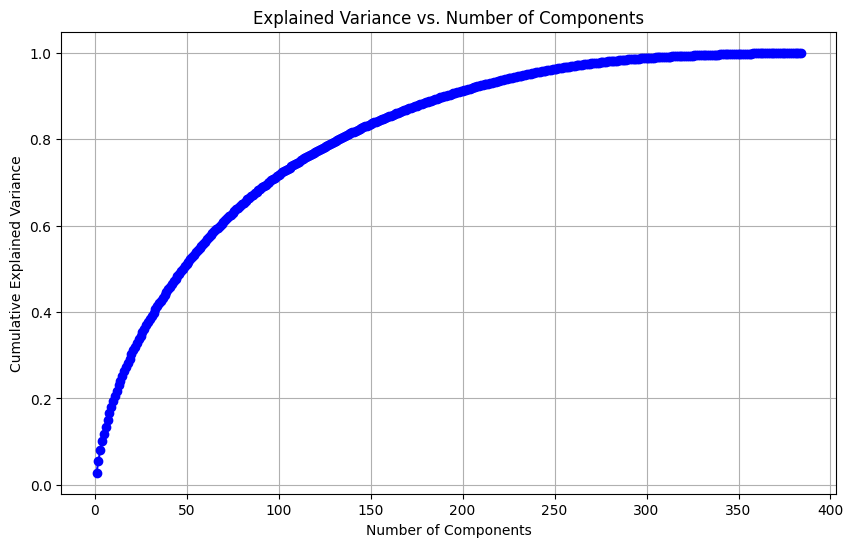

In [5]:
# Fit PCA and transform the data
pca = PCA()
data_transformed = pca.fit_transform(data)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the variance explained by each component
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='b')
plt.title('Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

### Clustering with K-means

#########%#########

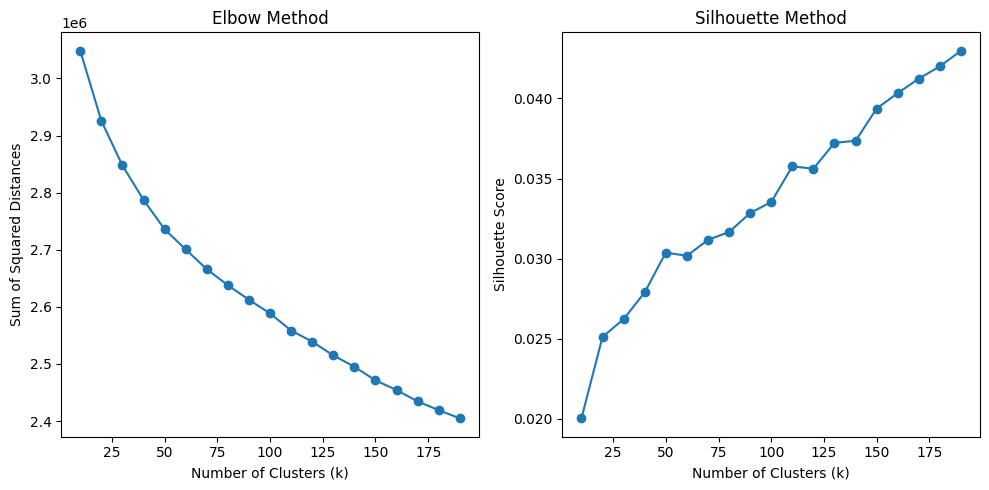

In [8]:
# Standardize the data (mean=0 and variance=1)
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data)

data_standardized, _ = train_test_split(data_standardized, test_size=0.9)

# Calculate the sum of squared distances for different values of k
sse = []
silhouette_scores = []
possible_k_values = np.arange(10, 200, 10)

for k in possible_k_values:
    if k%100 > 0:
        print('#', end='')
    else:
        print('%', end='')
    
    kmeans = KMeans(n_clusters=k,
                    random_state=420,
                   n_init="auto")
    kmeans.fit(data_standardized)
    sse.append(kmeans.inertia_)  # Sum of squared distances to closest cluster center
    silhouette_scores.append(silhouette_score(data_standardized,
                                              kmeans.labels_))

# Plot the elbow curve
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(possible_k_values, sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')

plt.subplot(1, 2, 2)
plt.plot(possible_k_values, silhouette_scores, marker='o')
plt.title('Silhouette Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [49]:
# Specify the number of clusters
num_clusters = 30

# Create a k-means clustering model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit the model to your data
kmeans.fit(data)

# Get the cluster labels for each vector
cluster_labels = kmeans.labels_

# Find the indices of data in the first cluster
first_cluster_indices = np.where(cluster_labels == 0)[0]

# Randomly select 10 indices from the first cluster
random_10_indices = np.random.choice(first_cluster_indices, size=10, replace=False)

# Retrieve the text data for the selected indices
selected_text_data = data_text[random_10_indices]

# Print the text data for the selected indices
for i, text in enumerate(selected_text_data):
    print(f"Index {random_10_indices[i]}: {text}")

/home/kacper/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Index 45846: how much of a non-vascular plant is involved in photosynthesis ?
Index 76484: in the semi-additive process , what do the areas exposed by the mask become at the end ?
Index 22352: what material sometimes used for dog chews reacts similarly to wood because of its water content ?
Index 26998: what substance settles and make beer clear after it ferments ?
Index 65891: what material is useful in glassmaking because of its slow evaporation ?
Index 81235: what company has developed leds that can operate on ac power ?
Index 62490: how does burrowers ' loosening help the soil ?
Index 15738: what is the shiniest type of coated paper ?
Index 73590: what is a glass master ?
Index 36588: what product is bitumen used in manufacturing as a sealant ?


### Pairwise distances

In [11]:
# Calculate pairwise Euclidean distances between data
data_sample, _ = train_test_split(data, test_size=0.9)

distances = euclidean_distances(data_sample, data_sample)

# Set the diagonal values (distances to self) to a large number
np.fill_diagonal(distances, np.inf)

In [12]:
def question_pairs(distance_threshold, num_random_pairs=10):
    # Find the indices of pairs with a distance smaller than the given threshold
    pairs_below_threshold = np.where(distances < distance_threshold)

    # Create a list of pairs and their distances
    pairs_and_distances = list(zip(pairs_below_threshold[0], pairs_below_threshold[1], distances[pairs_below_threshold]))

    # Shuffle the pairs to get a random order
    np.random.shuffle(pairs_and_distances)

    # Select random pairs with a distance smaller than the given threshold
    random_pairs = pairs_and_distances[:num_random_pairs]

    # Print the random pairs and their distances (dissimilarities)
    for i, (index1, index2, distance) in enumerate(random_pairs):
        question1 = data_text[index1]
        question2 = data_text[index2]
        print(f"Pair {i + 1}:\nQuestion 1: '{question1}'\nQuestion 2: '{question2}'\nDistance: {np.round(distance, 5)}\n")

In [13]:
question_pairs(0.5)

Pair 1:
Question 1: 'who was a host on all seasons of american idol ?'
Question 2: 'what kind of tree was the bodhi tree ?'
Distance: 0.0

Pair 2:
Question 1: 'media such as a radio and television have started to make their presences felt since what years ?'
Question 2: 'what label did kanye begin to work for in 2000 ?'
Distance: 0.2670300006866455

Pair 3:
Question 1: 'where is the largest solar power plant in the world located ?'
Question 2: 'in what year did the sister city program of the city of new york , inc. have its name changed ?'
Distance: 0.31995999813079834

Pair 4:
Question 1: 'what is a single coat ?'
Question 2: 'what was frédéric prone to during early childhood as a result of his slight build ?'
Distance: 0.4222300052642822

Pair 5:
Question 1: 'in what season was donna summer a guest judge on american idol ?'
Question 2: 'despite its imperfection , what are now considered valuable achievements of principia mathematica ?'
Distance: 0.4902699887752533

Pair 6:
Question 1

In [14]:
question_pairs(1)

Pair 1:
Question 1: 'what was burned during these boycotts ?'
Question 2: 'when was buddha alive ?'
Distance: 0.9812600016593933

Pair 2:
Question 1: 'where was kanye arrested at for the second time ?'
Question 2: 'how much greater was the energy of this quake than that released in the earthquake of 1995 in japan ?'
Distance: 0.9973700046539307

Pair 3:
Question 1: 'who designed chopin 's tombstone ?'
Question 2: 'the delay in support by certain powerful members meant the convention was largely powerless for over how many decades ?'
Distance: 0.9933199882507324

Pair 4:
Question 1: 'how many aftershocks were there within 72 hours ?'
Question 2: 'at what age did chopin move to paris ?'
Distance: 0.9763000011444092

Pair 5:
Question 1: 'when is the hd version of twilight princess slated for launch ?'
Question 2: 'how many seats do democrats hold in the state us senate 's seats ?'
Distance: 0.9980300068855286

Pair 6:
Question 1: 'how long was the fault where the quake occurred ?'
Questio

### DSI

In [50]:
idx, _ = train_test_split([i for i in range(len(data))], test_size=0.9, stratify=kmeans.labels_)

In [51]:
# IMPORTS
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktParameters
from transformers import BertTokenizer, BertModel, BertConfig
import string
import time
from tqdm import tqdm
import torch

# DATA
questions = pd.read_csv("squad.txt", sep='|', header=None).rename(columns={0: 'question'})
questions = questions.iloc[idx, :]
questions["ID"] = idx
questions_dci = questions.rename(columns={'question':'Story'})

"""

All code in this file is licensed to John D. Patterson from The Pennsylvania State University, 04-04-2022, under the Creative Commons Attribution-NonCommerical-ShareAlike 4.0 International (CC BY-NC-SA 4.0)

Link to License Deed https://creativecommons.org/licenses/by-nc-sa/4.0/

Link to Legal Code https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode

Please cite Johnson, D. R., Kaufman, J. C., Baker, B. S., Barbot, B., Green, A., van Hell, J., … Beaty, R. (2021, December 1). Extracting Creativity from Narratives using Distributional Semantic Modeling. Retrieved from psyarxiv.com/fmwgy in any publication or presentation

"""


# USER EDIT
#filename = "study1_OSF FINAL.csv"

# INITIALIZE BERT AND TOKENIZERS
model = BertModel.from_pretrained("bert-large-uncased", output_hidden_states = True).cuda() # initialize BERT model instance
model.eval()
segmenter = PunktSentenceTokenizer() # initialize segmenter: does sentence segmentation, returns list
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased') # initialize BERT tokenizer
cos = torch.nn.CosineSimilarity(dim = 0)

# LOAD DATA
#d = pd.read_csv(filename, usecols = ["ID","Story"])
d = questions_dci
# d = d.head(1) # you can uncomment this if you want to do a trial run with only the first participant's story instead of the whole dataset
#out_df = pd.read_csv(filename)

# CREATE STORAGE DICTIONARY # keys = participant IDs
s = {}

# CREATE POST-EMBEDDING FILTERING LIST
filter_list = np.array(['[CLS]', '[PAD]', '[SEP]', '.', ',', '!', '?'])

# SEGMENT DATA INTO SENTENCES
start_time = time.time()
for index, row in tqdm(d.iterrows()):
    ID = row["ID"]  # get current participant ID
    text = row["Story"]  # get current story
    s[ID] = {}  # add dict entry for subject and create nested dict to store subject data

    # TRAIN SENTENCE SEGEMENTER AND SEGMENT SENTENCE
    segmenter.train(text) # train the segmenter on the text first (unsupervised algorithm that is pretrained and can improve with added training)
    sentences_from_segmenter = segmenter.tokenize(text) # apply the additionally-trained segmenter to the text

    # LOOP OVER SENTENCES AND GET BERT FEATURES (LAYERS 6 & 7)
    features = []  # initialize list to store dcos values, one for each sentence
    words = []
    for i in range(len(sentences_from_segmenter)):  # loop over sentences
        sentence = sentences_from_segmenter[i].translate(str.maketrans('', '', string.punctuation))
        sent_tokens = tokenizer(sentence, max_length = 50, truncation = True, padding = 'max_length', return_tensors="pt")
        sent_words = [tokenizer.decode([k]) for k in sent_tokens['input_ids'][0]]
        sent_indices = np.where(np.in1d(sent_words, filter_list, invert = True))[0]  # we'll use this to filter out special tokens and punctuation
        with torch.no_grad():
            sent_output = model(**sent_tokens.to("cuda") )# feed model the sentence tokens and get outputs
            hids = sent_output.hidden_states # isolate hidden layer activations
        layer6 = hids[6] # isolate layer 6 hidden activations
        layer7 = hids[7] # do the same for layer 7

        for j in sent_indices:  # loop over words and create list of all hidden vectors from layers 6 & 7; additionally store number of words (doubled, to account for layer 6 and 7 duplicates)
            words.append(sent_words[j])
            words.append(sent_words[j])
            features.append(layer6[0,j,:])  # layer 6 features
            features.append(layer7[0,j,:])  # layer 7 features

    # GET DCOS VALUES FOR STORY
    num_words = len(words) # number of words, in terms of hidden activation vectors (2*words)
    lower_triangle_indices = np.tril_indices_from(np.random.rand(num_words, num_words), k = -1)  # creates a matrix that represents words*2 (i.e., from word representations from both layer 6+7) and gets the indices of the lower triangle, omitting diagonal (k = -1)A
    story_dcos_vals = []  # intialize storage for dcos of current sentence
    for k in range(len(lower_triangle_indices[0])): # loop over lower triangle indices
        features1 = features[lower_triangle_indices[0][k]]
        features2 = features[lower_triangle_indices[1][k]]
        dcos = (1-cos(features1, features2))  # compute dcos
        story_dcos_vals.append(dcos) # store dcos value in list

    mean_story_dcos = torch.mean(torch.stack(story_dcos_vals)).item()  # get average story dcos
    s[ID]["DSI"] = mean_story_dcos

# MERGE OUTPUT WITH INPUT DATAFRAME
dsi_df = pd.DataFrame.from_dict(s, orient = "index") # make pandas dataframe from DSI dictionary
dsi_df["ID"] = dsi_df.index
# dsi_df.to_csv('DSI_output.csv', index = False) # save updated dataframe
elapsed_time = time.time()-start_time # get elapsed time to compute DSI values
print('elapsed time: ' + str(elapsed_time)) # display elapsed time (in seconds)

8663it [07:21, 19.62it/s]

elapsed time: 441.4655623435974


### t-SNE

In [17]:
from sklearn.preprocessing import OneHotEncoder
from kmodes.kprototypes import KPrototypes
import seaborn as sns

In [18]:
x = data[idx]
minilabs = kmeans.labels_[idx]
x.shape

(8663, 384)

In [19]:
x2 = TSNE().fit_transform(x)

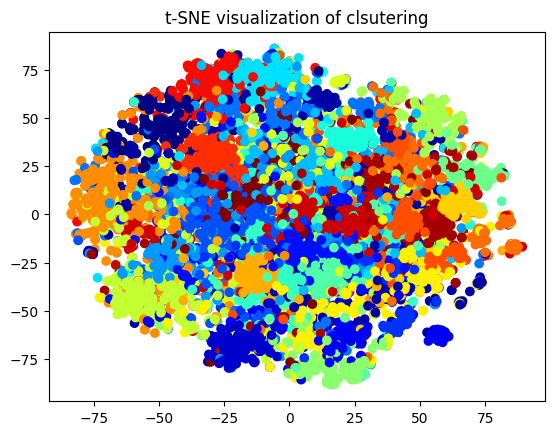

In [20]:
plt.scatter(x2[:, 0], x2[:, 1], c=minilabs, cmap="jet")
plt.title("t-SNE visualization of clsutering")
plt.show()

In [53]:
dsis = dsi_df
dsis.index = dsis["ID"]
dsis = dsis.reindex(idx)

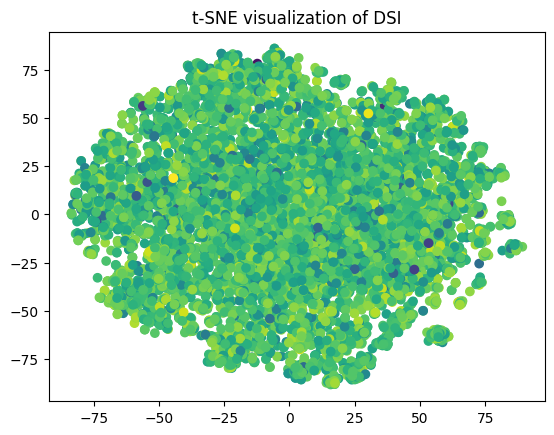

In [22]:
plt.scatter(x2[:, 0], x2[:, 1], c=dsis["DSI"])
plt.title("t-SNE visualization of DSI")
plt.show()

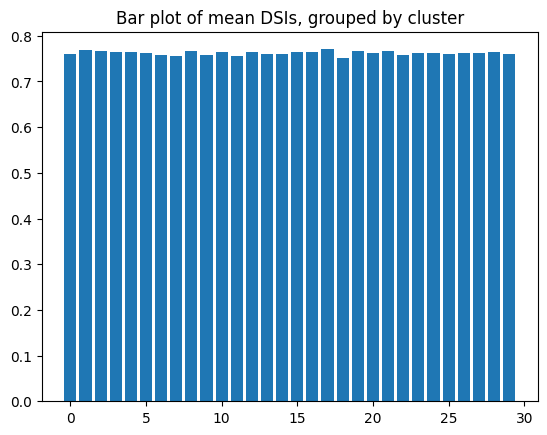

In [23]:
dsis["cluster"]= minilabs
plt.bar(
    [i for i in range(30)],
    dsis.groupby("cluster").mean()["DSI"]
)
plt.title("Bar plot of mean DSIs, grouped by cluster")
plt.show()

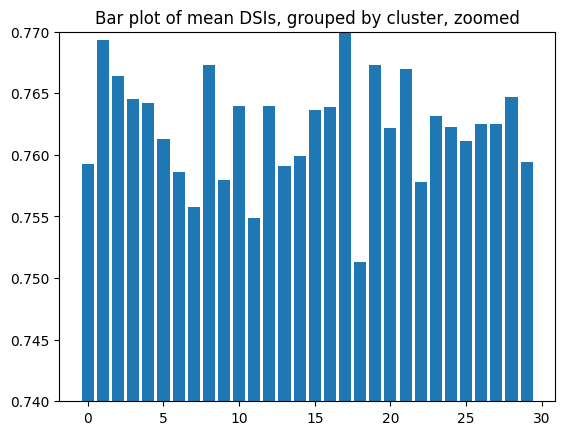

In [24]:
dsis["cluster"]= minilabs
plt.bar(
    [i for i in range(30)],
    dsis.groupby("cluster").mean()["DSI"]
)
plt.ylim(0.74, 0.77)
plt.title("Bar plot of mean DSIs, grouped by cluster, zoomed")
plt.show()

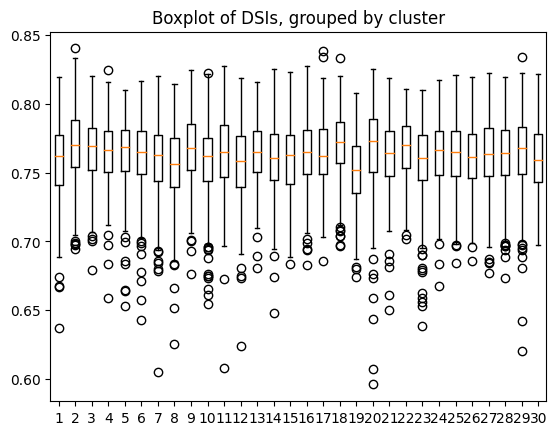

In [25]:
plt.boxplot([y["DSI"] for x, y in dsis.groupby('cluster')])
plt.title("Boxplot of DSIs, grouped by cluster")
plt.show()

In [26]:
ask_words = ["none", "how", "what", "when", "where", "which", "who", "why", "if", "other"]
ask_words_dict = {word: num for num, word in enumerate(ask_words)}

def assign_label(question):
    for word in ask_words:
        if word in question:
            return word
    return "none"

def create_ask_words_labels(questions):
    labels_ask_words = []
    for question in questions:
        labels_ask_words.append(assign_label(question))
    return labels_ask_words

In [27]:
labels_ask_words = create_ask_words_labels(data_text[idx])

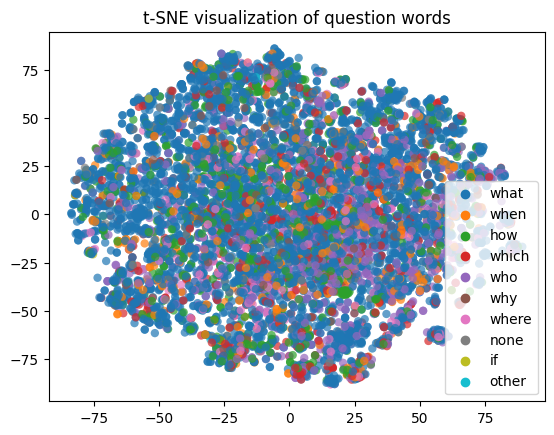

In [28]:
sns.scatterplot(x= x2[:, 0], y=x2[:, 1], hue=labels_ask_words, alpha=0.7, edgecolor="none")
plt.title("t-SNE visualization of question words")
plt.show()

In [29]:
words_ohe = OneHotEncoder().fit_transform([[el] for el in labels_ask_words]).todense()

In [30]:
combined = np.hstack((x, words_ohe, 10*dsis["DSI"].values.reshape(-1, 1)))
combined = np.asarray(combined)
pca = PCA(n_components = 10)
combined = pca.fit_transform(combined)

In [31]:
kmeans2 = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
kmeans2.fit(combined)
cluster_labels_2 = kmeans2.labels_
cluster_labels_2

array([16, 24,  1, ..., 23, 28, 29], dtype=int32)

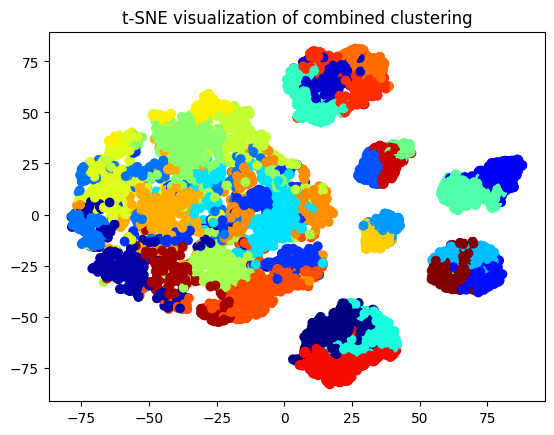

In [32]:
x3 = TSNE().fit_transform(combined)
plt.scatter(x3[:, 0], x3[:, 1], c=cluster_labels_2, cmap="jet")
plt.title("t-SNE visualization of combined clustering")
plt.show()

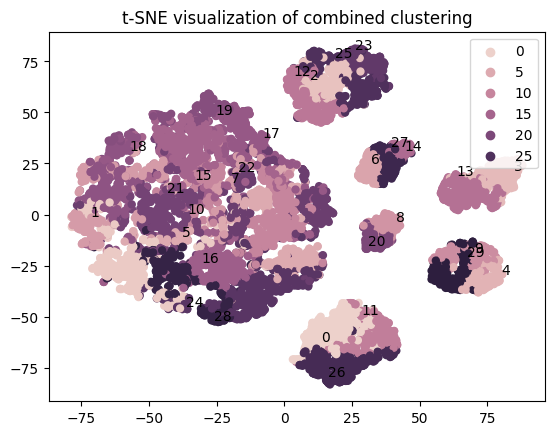

In [33]:
sns.scatterplot(x=x3[:, 0], y=x3[:, 1], hue=cluster_labels_2, edgecolor="none")
plt.title("t-SNE visualization of combined clustering")
added = []
for x_1, x_2, el in zip(x3[:, 0], x3[:, 1], cluster_labels_2):
    if el not in added:
        plt.text(x_1, x_2, el)
        added.append(el)
plt.show()

In [34]:
cluster_labels_2

array([16, 24,  1, ..., 23, 28, 29], dtype=int32)

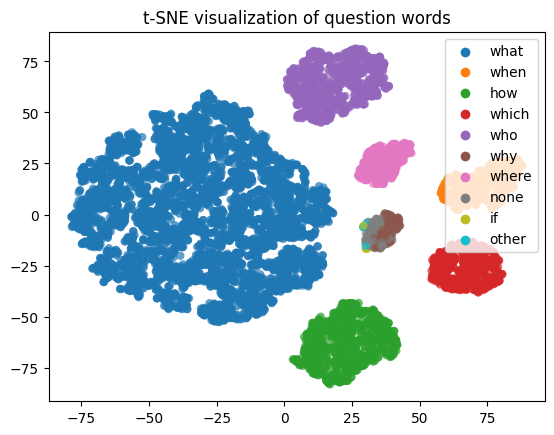

In [35]:
sns.scatterplot(x= x3[:, 0], y=x3[:, 1], hue=labels_ask_words, alpha=0.7, edgecolor="none")
plt.title("t-SNE visualization of question words")
plt.show()

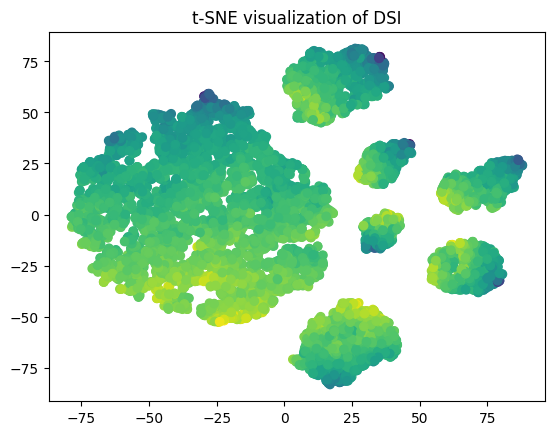

In [36]:
plt.scatter(x3[:, 0], x3[:, 1], c=dsis["DSI"])
plt.title("t-SNE visualization of DSI")
plt.show()

In [37]:
idx = np.array(idx)
print("\n".join(data_text[idx[np.logical_or(cluster_labels_2 == 8, cluster_labels_2 == 26)]]))

why was king george vi 's personal assent in 1939 noteworthy ?
how far do egyptian beaches extend ?
why did some music lovers frown upon diaphragming ?
how many manufacturing workers does paris have ?
how many square miles was the city in 1822 ?
how do the indigenous peoples explain how they came to live in the americas ?
how many of the indigenous peoples in mexico speak an indigenous language ?
how many times can a nigerian president be elected ?
gautama did n't like the religious teaching he initially found because of why ?
how large is the smallest canton ?
why was a gap left at the mouth of leyden jars ?
how many states are in germany ?
who appointed eisenhower as supreme allied commander in europe ?
how deep is the fault ?
how many russians were in defense ?
how deep are the clay and sands foundations of houston ?
how do npos handle staffing ?
why was the english order of the dominicans so successful in england ?
how did the war impact france financially ?
how many members are in

## LDA

In [1]:
from gensim.models import LdaMulticore
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
import nltk
import pprint
from nltk.corpus import stopwords

NUM_TOPICS = 5

### General LDA

In [4]:
# further preprocessing of questions from the source
def split_questions(questions):
    split_questions = []
    for question in questions:
        split_questions.append(simple_preprocess(question, deacc=True))
    return split_questions

questions_split = split_questions(sentences)

In [5]:
# a function to find and print all the topics in the dataset (found by LDA, so as collections of words)
def find_print_topics(sentences, **kwargs):
    id2word = corpora.Dictionary(sentences)
    corpus = [id2word.doc2bow(q) for q in sentences]
    if kwargs:
        lda_model = LdaMulticore(corpus=corpus,
                            id2word=id2word,
                            num_topics=NUM_TOPICS,
                                 random_state=12,
                                 **kwargs)
    else:
        lda_model = LdaMulticore(corpus=corpus,
                            id2word=id2word,
                            num_topics=NUM_TOPICS,
                                random_state=12)
    pprint.pprint(lda_model.print_topics())
    return corpus, lda_model

In [6]:
_ = find_print_topics(questions_split)

[(0,
  '0.063*"the" + 0.043*"what" + 0.033*"to" + 0.025*"did" + 0.024*"in" + '
  '0.016*"who" + 0.013*"was" + 0.013*"does" + 0.013*"how" + 0.012*"on"'),
 (1,
  '0.101*"the" + 0.058*"what" + 0.051*"of" + 0.030*"in" + 0.024*"to" + '
  '0.020*"was" + 0.019*"did" + 0.015*"is" + 0.009*"and" + 0.008*"who"'),
 (2,
  '0.060*"what" + 0.045*"in" + 0.033*"the" + 0.033*"of" + 0.026*"is" + '
  '0.023*"to" + 0.015*"how" + 0.013*"are" + 0.013*"was" + 0.009*"many"'),
 (3,
  '0.098*"the" + 0.051*"what" + 0.042*"was" + 0.039*"of" + 0.026*"in" + '
  '0.021*"is" + 0.019*"did" + 0.018*"who" + 0.017*"when" + 0.017*"to"'),
 (4,
  '0.070*"what" + 0.046*"the" + 0.043*"of" + 0.029*"in" + 0.023*"is" + '
  '0.018*"did" + 0.015*"to" + 0.014*"how" + 0.012*"and" + 0.012*"for"')]


Topics are mostly stopwords; removing them

In [6]:
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')

def remove_stopwords(question):
    question_removed = [word for word in question if word not in stop_words]
    return question_removed

questions_split_no_stopwords = [remove_stopwords(q) for q in questions_split]
corpus, lda_model = find_print_topics(questions_split_no_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jakub\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[(0,
  '0.009*"year" + 0.009*"many" + 0.007*"name" + 0.006*"police" + 0.005*"new" + '
  '0.005*"place" + 0.005*"made" + 0.005*"use" + 0.005*"used" + 0.004*"greece"'),
 (1,
  '0.019*"many" + 0.017*"eisenhower" + 0.009*"bronx" + 0.008*"people" + '
  '0.006*"year" + 0.006*"name" + 0.005*"population" + 0.005*"much" + '
  '0.004*"first" + 0.003*"greece"'),
 (2,
  '0.011*"first" + 0.010*"many" + 0.007*"group" + 0.006*"used" + '
  '0.006*"called" + 0.005*"world" + 0.004*"much" + 0.004*"year" + '
  '0.004*"system" + 0.004*"country"'),
 (3,
  '0.011*"new" + 0.010*"many" + 0.009*"year" + 0.008*"city" + 0.008*"first" + '
  '0.007*"used" + 0.006*"type" + 0.005*"two" + 0.004*"called" + '
  '0.004*"become"'),
 (4,
  '0.009*"many" + 0.008*"name" + 0.008*"jehovah" + 0.008*"type" + '
  '0.007*"witnesses" + 0.007*"year" + 0.006*"one" + 0.005*"first" + '
  '0.004*"war" + 0.004*"kind"')]


In [7]:
topic_dict = {0:"year many",
1:"Eisenhower people",
2:"first many",
3:"many new",
4:"many name"}

In [8]:
assigned_topics = []
assigned_topics_nums = []
for corp in corpus:
    assigned_topics.append(topic_dict[max(lda_model.get_document_topics(corp), key=lambda x: x[1])[0]])
    assigned_topics_nums.append(max(lda_model.get_document_topics(corp), key=lambda x: x[1])[0])

In [11]:
vals, counts = np.unique(np.array(assigned_topics), return_counts=True)

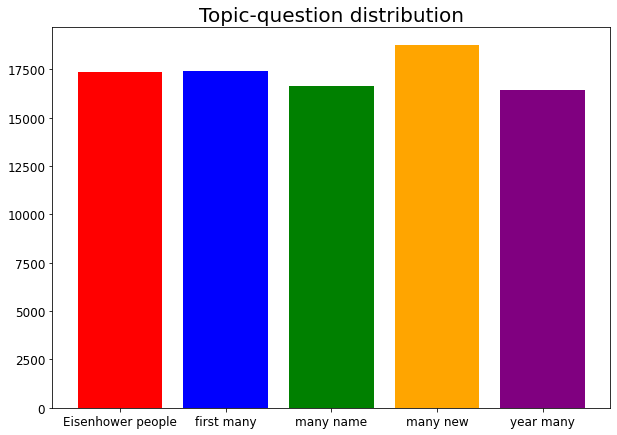

In [12]:
topic_colors = ["red", "blue", "green", "orange", "purple"]

plt.figure(figsize=(10,7))
plt.bar(vals, counts, color=topic_colors)
plt.title("Topic-question distribution", fontsize=20)
plt.tick_params(labelsize=12)
plt.show()

In [13]:
# Different localization configurations for word groups

localization = [(0.4,0.7)]
for i in (-0.3, 0, 0.25):
    for j in (0.1, 0, -0.1):
        localization.append((0.5+i, 0.5+j))
        
localization_narrow = [(0.4,0.7)]
for i in (-0.3, 0, 0.15):
    for j in (0.1, 0, -0.1):
        localization_narrow.append((0.5+i, 0.5+j))   
        
localization_narrower = [(0.4,0.7)]
for i in (-0.25, 0, 0.15):
    for j in (0.1, 0, -0.1):
        localization_narrower.append((0.5+i, 0.5+j)) 
        
localization_wide = [(0.4,0.7)]
for i in (-0.3, 0, 0.3):
    for j in (0.1, 0, -0.1):
        if i == -0.3:
            localization_wide.append((0.5+i, 0.5+j))
        else:
            localization_wide.append((0.5+i, 0.4+j))
        


In [14]:
locations = [localization_narrower, localization_wide, localization_narrow, localization_narrower, localization]

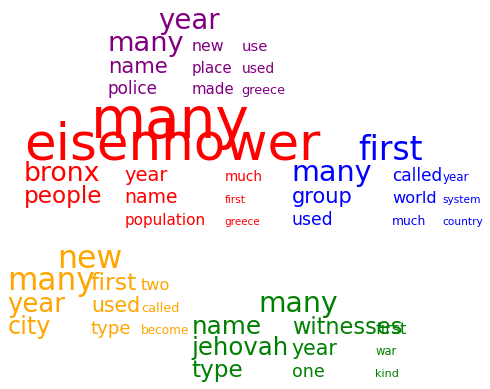

In [15]:
global_locations = [(-0.3,0.8), (-0.5,0.3), (0.3,0.2), (-0.6,-0.3), (0,-0.5)]
topic_colors = ["purple", "red", "blue", "orange", "green"]
for i in range(5):
    for j in range(len(lda_model.show_topic(0))):
        plt.text(locations[i][j][0] + global_locations[i][0],locations[i][j][1] + global_locations[i][1],
                 lda_model.show_topic(i)[j][0], size=lda_model.show_topic(i)[j][1]*3000, 
                c=topic_colors[i])
plt.axis('off')
plt.show()

Due to the inherit randomness of the LDA method, those visualisations differ slightly from the ones on the presentation. However, the message remains unchanged and is even strenghtened, because this method yields unsatisfactory results each time it is computed. Let's now check the clustering visualisation using t-SNE:

In [ ]:
# bringing back data from t-SNE embeddings
tsne_embeddings = x2
idxes = idx

In [ ]:
subset_assigned_topics = np.array(assigned_topics_nums)[idxes]

In [ ]:
colors = {i: color for i, color in zip(range(len(topic_colors)), topic_colors)}
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=[colors[w] for w in subset_assigned_topics])
plt.title("t-SNE visualization of clustering for LDA")
plt.show()

As we can see, the visualisation is not really promising -- we can investigate further by checking questions inside clusters

In [ ]:
sentences_type1 = np.array(sentences)[np.array(assigned_topics_nums) == 1]
sentences_type2 = np.array(sentences)[np.array(assigned_topics_nums) == 2]

In [54]:
## type eisenhower people
print("\n".join(np.random.choice(sentences_type1, size=20, replace=False)))

who is finding themselves in a double minority in the us ?

how many new cases were filed in 2010 ?

what is the average humidity in july as a percentage ?

what is the name of the coal field

when did the borgata open ?

what might help migrating birds navigate ?

how many employees work for norman regional hospital ?

the repression of what is also considered political corruption ?

what art style was used inthe design of the reading room ?

how long did the operation in gaza in november last ?

how much did the armenian gdp decrease from 1989-1993

what high profile controversial project was von neumann a prinipal of ?

what percent of the population are between 14 to 30 years old ?

when did the yuan dynasty rule ?

what was disallowed in advertising during the two months prior to the general election ?

what type of birds may moult only once every few years ?

where does arsenal 's total league championships place it as compared to other english teams ?

what was the solution for 

In [55]:
## first many cluster
print("\n".join(np.random.choice(sentences_type2, size=20, replace=False)))

who is the most recent member to join the ibm board of directors ?

what are people who have ancestral roots in germany , but now live outside of germany called ?

where do many modern day hunter-gatherers live ?

what grade did yale get on their sustainable endowments institute 's college sustainability report card 2008 ?

when does spring start in zhejiang ?

in what form do some viruses store their entire genome ?

who is credited as giving zinc its name ?

in what area of italy is the largest collection of mosaics in the world ?

to what world organization does tuvalu belong ?

what factor is very strong in southampton that encourages redevelopment of the city ?

to which university does richard h. sander belong ?

who created a pathway for education for women in the islamic world ?

what was the name of the royal charter ?

through which manner are unabsorbed matter and waste products excreted ?

what 3 parts make up the cpu ?

what is the climate like on the summits ?

when did p

As we can see, there are no visible clear topics inside clusters.

### LDA inside 'interesting' clusters

We can also investigate topics found in the LDA inside the "interesting" clusters (as shown on the presentation, the small cluster with both the "if" questions and questions without any meaningful interrogative word)

In [56]:
clusters_tsne = cluster_labels_2

In [57]:
cluster_8_questions = np.array(questions_split, dtype=object)[idxes][clusters_tsne==8]

In [58]:
cluster_26_questions = np.array(questions_split, dtype=object)[idxes][clusters_tsne==26]

In [59]:
# Topics for interesting cluster 8
find_print_topics(cluster_8_questions)

[(0,
  '0.054*"the" + 0.044*"why" + 0.021*"of" + 0.018*"to" + 0.017*"was" + '
  '0.011*"did" + 0.010*"in" + 0.008*"and" + 0.008*"are" + 0.007*"for"'),
 (1,
  '0.040*"why" + 0.037*"in" + 0.034*"the" + 0.020*"was" + 0.018*"to" + '
  '0.013*"were" + 0.011*"of" + 0.008*"is" + 0.006*"did" + 0.006*"do"'),
 (2,
  '0.023*"why" + 0.018*"the" + 0.015*"have" + 0.012*"and" + 0.011*"or" + '
  '0.011*"of" + 0.010*"do" + 0.010*"some" + 0.008*"is" + 0.007*"did"'),
 (3,
  '0.070*"the" + 0.047*"why" + 0.034*"did" + 0.025*"to" + 0.024*"of" + '
  '0.008*"not" + 0.007*"were" + 0.006*"are" + 0.006*"was" + 0.006*"is"'),
 (4,
  '0.042*"the" + 0.029*"of" + 0.027*"why" + 0.019*"to" + 0.018*"was" + '
  '0.016*"or" + 0.010*"are" + 0.010*"in" + 0.009*"that" + 0.008*"do"')]


([[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)],
  [(8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)],
  [(8, 1),
   (10, 1),
   (16, 1),
   (17, 1),
   (18, 1),
   (19, 1),
   (20, 1),
   (21, 1),
   (22, 1),
   (23, 1),
   (24, 1),
   (25, 1)],
  [(7, 1),
   (8, 1),
   (22, 1),
   (25, 1),
   (26, 1),
   (27, 1),
   (28, 1),
   (29, 1),
   (30, 1),
   (31, 1)],
  [(2, 1),
   (7, 1),
   (8, 1),
   (22, 1),
   (25, 2),
   (32, 1),
   (33, 1),
   (34, 1),
   (35, 1),
   (36, 1),
   (37, 1)],
  [(38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1)],
  [(2, 1),
   (7, 2),
   (25, 2),
   (46, 1),
   (47, 2),
   (48, 1),
   (49, 1),
   (50, 1),
   (51, 1),
   (52, 1),
   (53, 1)],
  [(8, 1),
   (25, 2),
   (54, 1),
   (55, 1),
   (56, 1),
   (57, 1),
   (58, 1),
   (59, 1),
   (60, 1),
   (61, 1),
   (62, 1)],
  [(8, 1), (10, 1), (63, 1), (64, 1), (65, 1)],
  [(10, 1),
   (66, 1),
   (67, 1),
   (68, 1),
   (69, 1),
   (70, 1)

In [60]:
# Topics for interesting cluster 26
find_print_topics(cluster_26_questions)

[(0,
  '0.053*"how" + 0.021*"in" + 0.014*"have" + 0.013*"much" + 0.012*"to" + '
  '0.012*"do" + 0.011*"was" + 0.011*"many" + 0.008*"of" + 0.006*"from"'),
 (1,
  '0.082*"how" + 0.031*"many" + 0.029*"is" + 0.021*"the" + 0.020*"in" + '
  '0.019*"to" + 0.014*"of" + 0.014*"are" + 0.014*"much" + 0.009*"did"'),
 (2,
  '0.103*"how" + 0.059*"many" + 0.040*"the" + 0.029*"in" + 0.023*"of" + '
  '0.020*"does" + 0.018*"have" + 0.016*"are" + 0.016*"is" + 0.015*"did"'),
 (3,
  '0.061*"how" + 0.041*"in" + 0.041*"many" + 0.025*"the" + 0.022*"are" + '
  '0.016*"to" + 0.014*"people" + 0.009*"was" + 0.008*"do" + 0.008*"were"'),
 (4,
  '0.077*"how" + 0.055*"the" + 0.055*"in" + 0.050*"many" + 0.036*"of" + '
  '0.024*"are" + 0.013*"was" + 0.013*"were" + 0.009*"there" + 0.007*"is"')]


([[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)],
  [(5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)],
  [(5, 1), (9, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)],
  [(1, 1),
   (5, 2),
   (13, 1),
   (16, 2),
   (18, 1),
   (19, 1),
   (20, 1),
   (21, 1),
   (22, 1),
   (23, 1),
   (24, 1),
   (25, 1)],
  [(5, 1),
   (9, 1),
   (13, 1),
   (16, 1),
   (21, 2),
   (23, 1),
   (26, 1),
   (27, 1),
   (28, 1),
   (29, 1),
   (30, 1)],
  [(5, 1), (9, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1)],
  [(5, 1), (16, 1), (37, 1), (38, 1), (39, 1), (40, 1)],
  [(5, 1), (9, 1), (13, 1), (41, 1), (42, 1), (43, 1)],
  [(13, 1),
   (44, 1),
   (45, 1),
   (46, 1),
   (47, 1),
   (48, 1),
   (49, 1),
   (50, 1),
   (51, 1)],
  [(5, 1), (16, 1), (38, 1), (52, 1), (53, 1)],
  [(5, 1), (9, 1), (13, 1), (54, 1), (55, 1), (56, 1)],
  [(5, 1),
   (16, 1),
   (29, 1),
   (41, 1),
   (52, 1),
   (57, 1),
   (58, 1),
   (59, 1),
   (60, 1),
   (61, 1)],
  [(1, 1), (5, 1),

### Seed guided LDA

Finally, we try the seed-guided LDA by asigning Bloom's taxonomy levels (and their synonyms) as topics.

In [16]:
from lda import guidedlda as glda
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize

There are some problems with installing guidedlda; [here is a workaround](https://github.com/dex314/GuidedLDA_WorkAround)

In [17]:
model = glda.GuidedLDA(n_topics=6, n_iter=1500, random_state=12, refresh=20)

In [18]:
import nltk
nltk.download('punkt')

corpus = sentences
vocab = list(set(word_tokenize(" ".join(sentences))))

vectorizer = CountVectorizer(ngram_range=(1,1),vocabulary=vocab)

X = vectorizer.fit_transform(corpus)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jakub\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [31]:
topic_seeds = [
    "remember",
    "understand",
    "apply",
    "analyze",
    "evaluate",
    "create"
]

In [32]:
model.fit(X, seed_topics=topic_seeds, seed_confidence=0.2)

INFO:lda:n_documents: 86635
INFO:lda:vocab_size: 39136
INFO:lda:n_words: 861457
INFO:lda:n_topics: 6
INFO:lda:n_iter: 1500
INFO:lda:<0> log likelihood: -9516532
INFO:lda:<20> log likelihood: -6457296
INFO:lda:<40> log likelihood: -6415568
INFO:lda:<60> log likelihood: -6394522
INFO:lda:<80> log likelihood: -6381665
INFO:lda:<100> log likelihood: -6372368
INFO:lda:<120> log likelihood: -6361161
INFO:lda:<140> log likelihood: -6352160
INFO:lda:<160> log likelihood: -6340932
INFO:lda:<180> log likelihood: -6330626
INFO:lda:<200> log likelihood: -6320434
INFO:lda:<220> log likelihood: -6309795
INFO:lda:<240> log likelihood: -6298346
INFO:lda:<260> log likelihood: -6288931
INFO:lda:<280> log likelihood: -6277982
INFO:lda:<300> log likelihood: -6268438
INFO:lda:<320> log likelihood: -6260530
INFO:lda:<340> log likelihood: -6252517
INFO:lda:<360> log likelihood: -6245058
INFO:lda:<380> log likelihood: -6238370
INFO:lda:<400> log likelihood: -6231329
INFO:lda:<420> log likelihood: -6225278
INF

In [33]:
labels_topic_seeds = np.argmax(model.transform(X), axis=1)

In [34]:
bloom_dict = {i:word for i, word in zip(range(len(topic_seeds)), topic_seeds)}

In [35]:
labels_topic_seeds_words = [bloom_dict[num] for num in labels_topic_seeds]

In [36]:
vals, counts = np.unique(np.array(labels_topic_seeds_words), return_counts=True)

In [37]:
bloom_idx = [4,5,1,0,3,2]

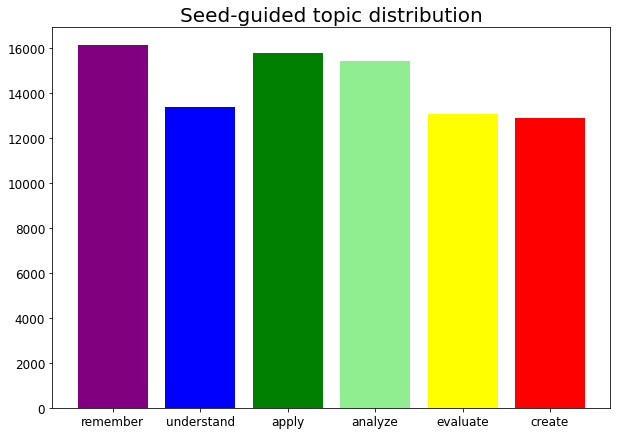

In [38]:
colors = ["purple", "blue", "green", "lightgreen", "yellow", "red"]

plt.figure(figsize=(10,7))
plt.bar(np.array(vals)[bloom_idx], np.array(counts)[bloom_idx], color=colors)
plt.title("Seed-guided topic distribution", fontsize=20)
plt.tick_params(labelsize=12)
plt.show()

In [54]:
DSI_metrics_sample = dsis

In [55]:
DSI_metrics_sample['label'] = np.array(labels_topic_seeds_words)[DSI_metrics_sample['ID']]

In [56]:
dfs = []
for _, df in DSI_metrics_sample.groupby('label'):
    dfs.append(df['DSI'])

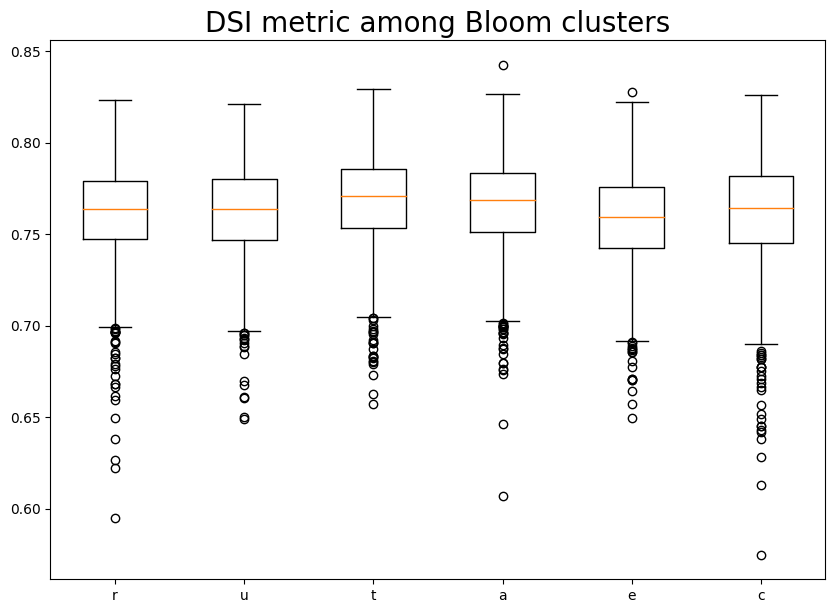

In [58]:
plt.figure(figsize=(10,7))
plt.boxplot(np.array(dfs, dtype=object)[bloom_idx])
ax = plt.gca()
ax.set_xticklabels(list(bloom_dict.values()))
plt.title("DSI metric among Bloom clusters", fontsize=20)
plt.show()

The results are still unsatisfying.

## Explanatory analysis

In [ ]:
label_dataframe

### Label number

In [ ]:
label_dataframe['label'].value_counts()

### Words per question

In [ ]:
label_dataframe['word_number'] = label_dataframe['question'].str.split().str.len()
label_dataframe['word_number']

In [ ]:
label_dataframe['word_number'].value_counts()

In [ ]:
label_dataframe['word_number'].hist(grid=False, bins=max(questions['word_number']))

### First word in a question

(extract the first word and try grouping questions by the interrogative pronoun used)

In [ ]:
# first word of a question
label_dataframe['first_word'] = label_dataframe['question'].str.split(expand=True)[0]

In [ ]:
label_dataframe['first_word']

### 40 most popular first words

In [ ]:
# most frequent types of questions
label_dataframe['first_word'].value_counts()[:40]

### Questions with interrogative words

We investigate the distribution of used "ask words" in our dataset

In [ ]:
labels_ask_words = create_ask_words_labels(sentences)

In [ ]:
plt.figure(figsize=(7,7))
plt.hist(labels_ask_words, rwidth=0.7)
plt.xticks([i-1 for i in range(len(ask_words)+1)], ['none']+ ask_words)
plt.show()

As we can see, questions with "what" clearly dominate the set

### Bloom's taxonomy dictionary

We will clean the expressions commonly associated with certain levels in the Bloom's taxonomy. The expressions were taken from [This link](https://tophat.com/blog/blooms-taxonomy-question-stems/)

In [ ]:
chars_to_remove = ['.', '?', '…', ',']
trans_table = str.maketrans('', '', ''.join(chars_to_remove))

In [ ]:
def process_bloom_dict(questions):
    questions = [word.translate(trans_table).lower().strip() for word in questions]
    return questions

In [ ]:
remember = ["Who", "What", "Where", "When", "Why", "How much", "How many", "True or false"]
remember = process_bloom_dict(remember)

In [ ]:
understand = ["How would you generalize...?",
              "How would you express...?",
              "What information can you infer from...?",
              "What did you observe...?",
              "What does this mean?",
              "Choose the correct answer.",
              "State in your own words.",
              "Is this the same as ?" ,
              "Give an example of...",
              "Choose the best definition of?",
              "This represents . . .",
              "Is it valid that ?",
              "What seems likely? Show in a graph, table, chart etc.",
              "Which statements best support ?",
              "What restrictions would you add?"]

understand = process_bloom_dict(understand)

In [ ]:
apply = ["How would you demonstrate...?",
         "How would you present...?",
         "Draw a story map.",
         "Explain a character’s decision-making process",
         "Do you know of another instance where ? ",
         "Can you group by characteristics such as ?" ,
         "Which factors would you change if …?",
         "What questions would you ask of this character…?",
         "How would you change...?",
         "How would you modify...?"]

apply = process_bloom_dict(apply)

In [ ]:
analyze = ["How can you sort the different parts...?",
           "What can you infer about...?",
           "What ideas validate...?",
           "How would you explain...?",
           "Which persuasive technique is used?",
           "Determine the point of view, bias, values, or underlying intent presented in the material.",
           "If … happened, what might the ending have been?",
           "How is … similar to …?",
           "What do you see as other possible outcomes?",
           "Why did … changes occur?",
           "Can you explain the result of…?"]

analyze = process_bloom_dict(analyze)

In [ ]:
evaluate = ["What criteria would you use to assess...?",
            "What sources could you use to verify...?",
            "What information would you use to prioritize..?",
            "What changes would you recommend to...?",
            "Do you believe …?",
            "How would you feel if …?",
            "How effective are …?",
            "What are the consequences of …?",
            "What influence will … have on our lives?",
            "What are the pros and cons of …?",
            "Why is … of value? What are the alternatives?"]

evaluate = process_bloom_dict(evaluate)

In [ ]:
create = ["What would happen if...?",
          "List the ways you can…?",
          "Can you brainstorm a list of new and unusual uses for …?",
          "Can you develop a proposal that would …?",
          "How would you test …?",
          "Which alternatives would you suggest for...?",
          "How else could you …?",
          "Describe a rule or common understanding about…?",
          "How would you design a plan to...?",
          "What could you invent to..?",
          "What changes would you make to revise...?"]

create = process_bloom_dict(create)

## STA data

Warning! The data is NDA-protected. Please do not share to unauthorized third parties!

In [ ]:
import os

In [ ]:
path = 'sta/Trint export 2023-11-08/'

In [ ]:
df = pd.read_csv(path + '19-09-23-141496-GAC-Council-DS-ES.mp3.csv')
failed_files = []
for file in os.listdir(path[:-1])[1:]:
    try:
        df = pd.concat((df, pd.read_csv(path+file)))
    except:
        failed_files.append(file)
        continue


In [ ]:
failed_files

In [ ]:
df.head()

We will now extract questions straight from these transcripts.

In [ ]:
possible_questions = []
for story in df["Text"]:
    if '?' in str(story):
        possible_questions.append(story)

In [ ]:
df.dropna()[df.dropna()['Text'].str.contains('\?')]

In [ ]:
import re

In [ ]:
questions_sta = []

for p in possible_questions:
    for text, text1 in zip(re.split('([?.!])', p)[:-1], re.split('([?.!])', p)[1:]):
        if '?' in text1:
            questions_sta.append(text + text1)

questions_sta

In [ ]:
# Saving questions into a file
with open('questions_STA.txt', 'w', encoding='utf8') as f:
    for line in questions_sta:
        f.write(line + "\n")

Having extracted and further investigated the questions, we have decided to not include them in our analysis, as we believe that they are of low quality.

## Text complexity

We will now investigate several text complexity metrics, starting with the simplest one, the longest words in a text

In [ ]:
longest_words = []
for q in sentences:
    longest_words.append(len(max(q.split(), key=len)))

In [ ]:
with open("longestwords.txt", 'w') as f:
    for label in longest_words:
        f.write(str(label)+ '\n')

Further metrics have been computed in the "computing_complexity_metrix.R" file.

What is more, we have found an impelemtation for the DSI measure [here](https://osf.io/6ye4j)

https://link.springer.com/article/10.3758/s13428-022-01986-2  <- DSI article link